## Understanding LOSC waveforms

Notebook to understand where LOSC waveforms come from.

   * Script used to make waveforms: https://trac.ligo.caltech.edu/LOSC/browser/trunk/tutorials/bbh_event/make_BBH_template.py


   

In [1]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

import pycbc
import lal as lal
import lalsimulation as lalsim

from pycbc.waveform import get_td_waveform

In [2]:
def make_waveform_pycbc(eventname='GW150914', phi_orb=0):
    fn_json = 'BBH_events_v3.json'
    events = json.load(open(fn_json,'r'))

    event = events[eventname]

    # masses
    m1 = event['m1']
    m2 = event['m2']
    a1 = event['a1']
    a2 = event['a2']
    approx = event['approx']
    f_min = event['f_min']
    fn_template = event['fn_template']

    # masses
    mtot = m1+m2
    eta = m1*m2/mtot**2
    mchirp = mtot*eta**(3./5.)

    print("M1: {0}".format(m1))
    print("M2: {0}".format(m2))
    print("a1: {0}".format(a1))
    print("a2: {0}".format(a2))
    
    # waveform sample rate
    fs = 4096
    deltaT = 1. / fs

    # frequency limits
    fmax = 4096.

    # Make a template at a fiducial distance of 1 Mpc, face on:
    distance = 1. * 1.e6 * lal.PC_SI   # 1 Mpc in m
    iota = 0.

    # waveform
    ampOrder = 0
    phOrder = 7

    # estimate f_min from desired chirp time
    tsun = lal.G_SI*lal.MSUN_SI/lal.C_SI**3
    tchirp = 16.+0.2
    f_min = 1./(np.pi*mtot*tsun) * (256.*eta*tchirp/(5.*mtot*tsun))**(-3./8.)
    
    hpt1, hct1 = get_td_waveform(approximant='SEOBNRv2',
                                 mass1=m1,
                                 mass2=m2,
                                 spin1z=a1,
                                 spin2z=a2,
                                 delta_t=1.0/4096,
                                 f_lower=f_min)

    # construct the time vector
    Ttot = len(hpt1) * deltaT
    t1 = np.arange(len(hpt1), dtype=float) * deltaT
    t1 = np.array(hpt1.sample_times)
    hp = np.array(hpt1.data)
    hc = np.array(hct1.data)
    hp = hp[t1 >= -16.]
    hc = hc[t1 >= -16.]
    hp = np.append(hp, np.zeros(32*fs - hp.size))
    hc = np.append(hc, np.zeros(32*fs - hc.size))
    th = t1[t1 >= -16.][0]+np.arange(hp.size, dtype=float) * deltaT
    
    return(th, hp, hc)


In [3]:
def check_waveform(eventname='GW150914'):

    #-- Read waveform from file
    fn_template = '{0}_4_template.hdf5'.format(eventname)
    f_template = h5py.File(fn_template, "r")
    template_p, template_c = f_template["template"][...]

    #-- Generate waveform using pycbc
    t1, hp, hc = make_waveform_pycbc(eventname, phi_orb=0)

    #-- Fit the phase
    for phi in np.arange(0,360):
        theta = phi*np.pi/180
        guess = np.sin(theta)*hp - np.cos(theta)*hc
        difference = (template_p-guess)
        error = difference.max()/hp.max()
        if error < 0.01: 
            print "Phase off-set is {0} degrees".format(phi)
            print("Max difference is {0}%".format(100*difference.max()/hp.max()))
            break
    
    plt.plot(t1,template_p, 'b')
    plt.plot(t1, guess, 'r--')
    plt.xlim(-0.1,0.01)

M1: 19.6427
M2: 6.7054
a1: 0.3998
a2: -0.0396
Phase off-set is 16 degrees
Max difference is 0.200034497105%


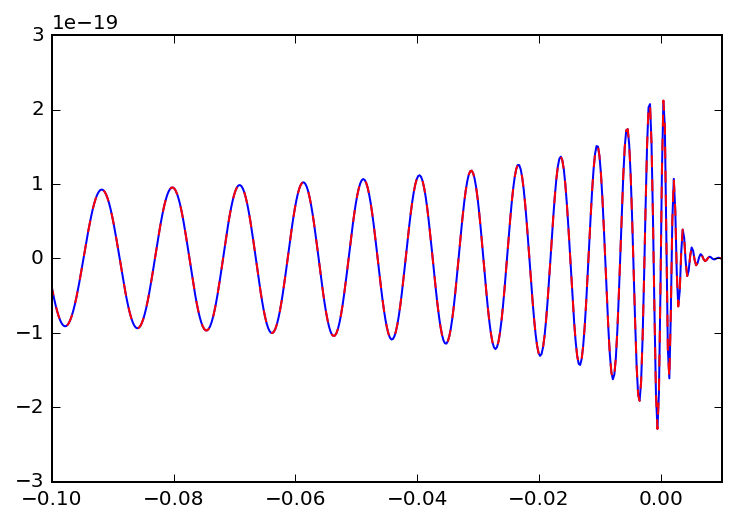

In [4]:
check_waveform('GW151226')

### GW150914

From PE paper:  https://arxiv.org/pdf/1602.03840.pdf

* Detector frame m1: 39.4
* Detector frame m2: 30.9
* A1: 0.32
* A2: 0.57

From PE run: 

* m1: 41.74275
* m2: 29.2368
* a1z: 0.3552
* a2z: -0.7691

M1: 41.743
M2: 29.237
a1: 0.355
a2: -0.769
Phase off-set is 215 degrees
Max difference is 0.125184559765%


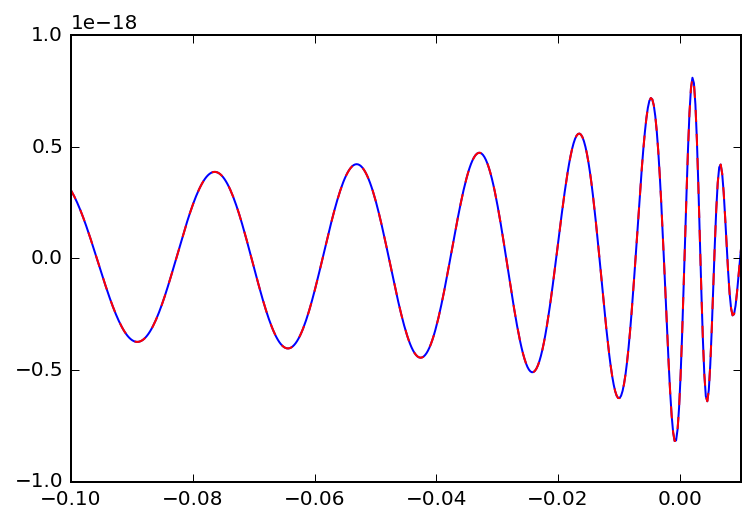

In [5]:
check_waveform('GW150914')

M1: 33.64
M2: 24.82
a1: -0.236
a2: 0.024
Phase off-set is 90 degrees
Max difference is 0.0141252541507%


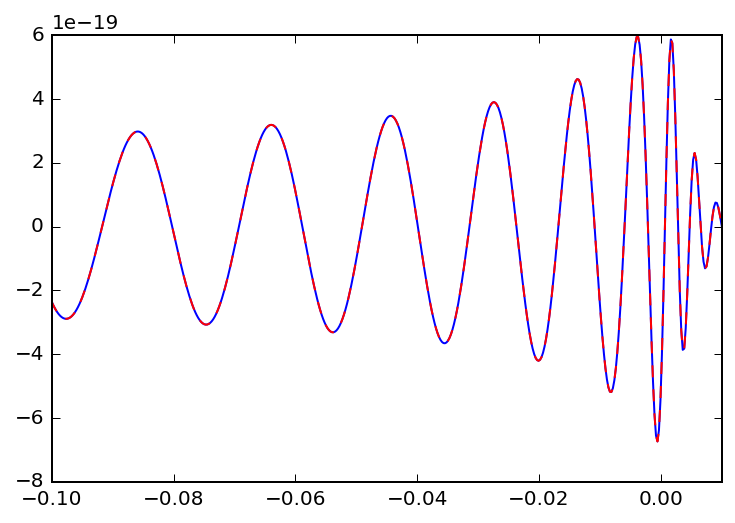

In [6]:
check_waveform('GW170104')

M1: 44.111
M2: 11.205
a1: 0.447
a2: -0.434
Phase off-set is 305 degrees
Max difference is 0.677746029633%


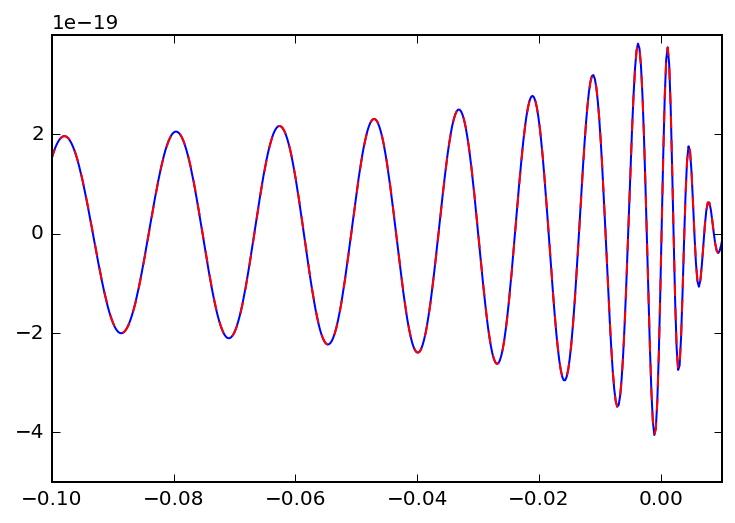

In [7]:
check_waveform('LVT151012')

M1: 41.743
M2: 29.237
a1: 0.355
a2: -0.769
Phase off-set is 215 degrees
Max difference is 0.125184559765%


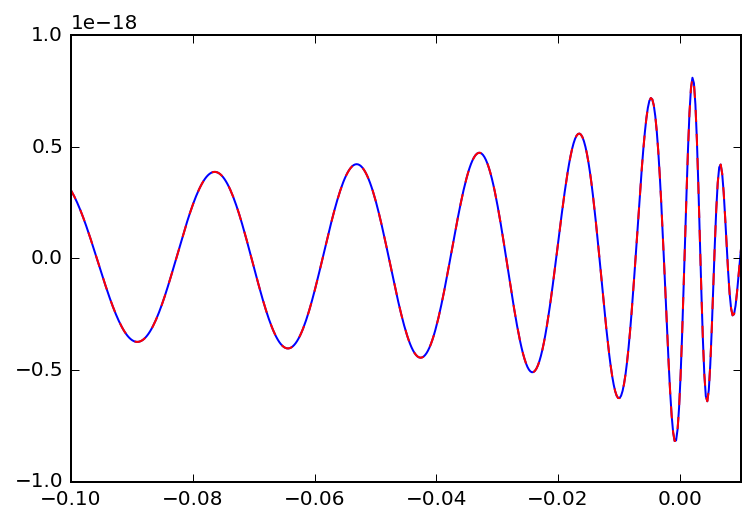

In [8]:
check_waveform('GW150914')